##pytorch

In [85]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

##Dane - wczytanie i konwersja obrazów do wektorów


In [115]:
class Dataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir) #images names
        abspath = os.path.abspath(img_dir) #absolute path of images

        self.img_list = [os.path.join(abspath, path) for path in path_list] #full path

        #set of transformations
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), #normalize [-1, 1]
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB') #image size (256, 256)
        return self.transform(img)
        #return img

In [87]:
db = Dataset('monet_jpg')

In [102]:
db[0].shape

torch.Size([3, 64, 64])

##Generator

In [92]:
class Generator(nn.Module):
    
    def __init__(self, noise_size, img_dim=64): #img_dim=64
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_size, out_channels=img_dim * 8, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(img_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=img_dim * 8, out_channels=img_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=img_dim * 4, out_channels=img_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim * 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=img_dim * 2, out_channels=img_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim),
            nn.ReLU(True),
          
            nn.ConvTranspose2d(in_channels=img_dim, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False), #out_channels RGB
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

In [99]:
Generator(100, 64)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [94]:
def noise(size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float()

In [95]:
noise(100)

tensor([ 7.2560e-01, -5.2040e-02, -2.6183e-01, -7.5270e-01,  4.3058e-01,
        -3.4439e-01,  5.4825e-01,  6.2242e-01, -3.9029e-01,  2.0453e-01,
         9.4736e-01, -7.4397e-01,  1.7020e-01,  2.8918e-01, -2.3673e-01,
        -9.7626e-01, -1.9156e-01, -7.0504e-01,  6.9746e-01,  4.5658e-02,
         9.2952e-01, -6.3752e-01, -5.0513e-01,  5.5139e-01, -8.8337e-01,
         8.5203e-04, -2.5821e-01, -4.2307e-01, -1.2986e-01, -9.5069e-01,
         2.3957e-01,  8.1578e-01, -6.2804e-01,  1.7717e-02, -7.3580e-01,
        -1.7983e-01,  8.5380e-01, -6.7353e-01,  5.3707e-01,  1.0103e-01,
        -5.4584e-02, -5.0909e-01,  3.4468e-01,  1.8683e-01, -9.2206e-01,
         7.0664e-01, -8.4096e-01, -7.8359e-01,  6.5487e-01,  5.8442e-01,
         4.2908e-01,  9.5879e-01,  1.7159e-01, -4.3112e-01, -6.3141e-01,
         7.4527e-01,  7.7571e-01,  9.1445e-01,  9.0119e-02,  8.0146e-01,
         2.1750e-01, -2.6794e-01, -2.0771e-01,  8.3117e-01, -7.6824e-01,
         5.0037e-01, -7.3697e-01, -3.8869e-01, -1.3

##Dyskryminator

In [96]:
class Discriminator(nn.Module):

    def __init__(self, img_dim=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, img_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(img_dim, img_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim * 2, img_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim * 4, img_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(img_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

##DCGAN 

In [100]:
class DCGAN:

    def __init__(self, noise_size, img_dim):
        self.noise_size = noise_size

        self.D = Discriminator(img_dim)
        self.G = Generator(noise_size, img_dim)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
        self.D.to(self.device)
        self.G.to(self.device)

        self.D.apply(self.weights_init)
        self.G.apply(self.weights_init)

        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

            
    def describe(self):
        print('Discriminator')
        print(self.D)

        print('\nGenerator')
        print(self.G)

    
    def __calculate_loss(self, output, labels):
        criterion = nn.BCELoss()
        return criterion(output.squeeze(), labels)


    def real_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.8

        return self.__calculate_loss(D_out, labels) 


    def fake_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.1
 
        return self.__calculate_loss(D_out, labels)


    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float().to(self.device)


    def train_generator(self, g_optim, size):
        g_optim.zero_grad()

        z = self.noise(size)
        fake_images = self.G(z)
        
        d_fake = self.D(fake_images)

        g_loss = self.real_loss(d_fake)

        g_loss.backward()
        g_optim.step()

        return g_loss.item()

    
    def train_discriminator(self, d_optim, real_images, size):
        d_optim.zero_grad()

        d_real = self.D(real_images.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)

        z = self.noise(size)
        fake_images = self.G(z)
      
        d_fake = self.D(fake_images)
        d_fake_loss = self.fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optim.step()

        return d_loss.item()


    def train(self, num_epochs, d_optim, g_optim, data_loader, z_size, sample_size, print_every=500):
        samples, losses = [], []

        z = self.noise((sample_size, z_size))

        self.D.train()
        self.G.train()

        print(f'Running on {self.device}')
        for epoch in range(num_epochs):
            for i, real_images in enumerate(data_loader):                    
                batch_size = real_images.size(0)

                d_loss = self.train_discriminator(d_optim, real_images, (sample_size, z_size))
                g_loss = self.train_generator(g_optim, (sample_size, z_size))

                if i % print_every == 0:
                    print('Epoch [{:5d}/{:5d}] | d_loss {:6.4f} | g_loss {:6.4f}'.format(
                        epoch+1,
                        num_epochs,
                        d_loss,
                        g_loss
                    ))

            losses.append( (d_loss, g_loss) )

            self.G.eval()
            samples.append( self.G(z) )
            self.G.train()

        with open('DCGAN_Sample_Output.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return samples, losses

##TRENING

In [118]:
# Dataset
monet_dataset = Dataset('monet_jpg') #data_dir
data_loader = DataLoader(monet_dataset, batch_size=16, shuffle=True)

noise_size = 128
img_size = 64

# Model
dcgan_model = DCGAN(noise_size, img_size)

# Oprimizer
lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(dcgan_model.D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(dcgan_model.G.parameters(), lr, [beta1, beta2])

# train
EPOCHS = 50
sample_size = 16 #nie wiem co to
sample_result, losses_history = dcgan_model.train(EPOCHS, d_optimizer, g_optimizer, data_loader, noise_size, 16, print_every=1000)

Running on cpu
Epoch [    1/   50] | d_loss 1.5468 | g_loss 3.1726
Epoch [    2/   50] | d_loss 1.8231 | g_loss 8.3974
Epoch [    3/   50] | d_loss 1.1918 | g_loss 2.6699
Epoch [    4/   50] | d_loss 1.0222 | g_loss 3.9864
Epoch [    5/   50] | d_loss 1.0760 | g_loss 2.5167
Epoch [    6/   50] | d_loss 1.2567 | g_loss 2.3289
Epoch [    7/   50] | d_loss 1.3291 | g_loss 4.8239
Epoch [    8/   50] | d_loss 0.8695 | g_loss 2.0635
Epoch [    9/   50] | d_loss 1.0407 | g_loss 2.8385
Epoch [   10/   50] | d_loss 1.1798 | g_loss 2.1867
Epoch [   11/   50] | d_loss 1.0315 | g_loss 3.0178
Epoch [   12/   50] | d_loss 1.1426 | g_loss 1.8593
Epoch [   13/   50] | d_loss 1.0859 | g_loss 1.7343
Epoch [   14/   50] | d_loss 1.2739 | g_loss 1.7738
Epoch [   15/   50] | d_loss 1.2342 | g_loss 3.1392
Epoch [   16/   50] | d_loss 1.0614 | g_loss 1.8145
Epoch [   17/   50] | d_loss 1.1293 | g_loss 4.1253
Epoch [   18/   50] | d_loss 0.9685 | g_loss 2.1289
Epoch [   19/   50] | d_loss 1.2058 | g_loss 1.34

In [ ]:
for i, real_images in enumerate(data_loader):                    
  print(real_images.size(0))

##Wystawa

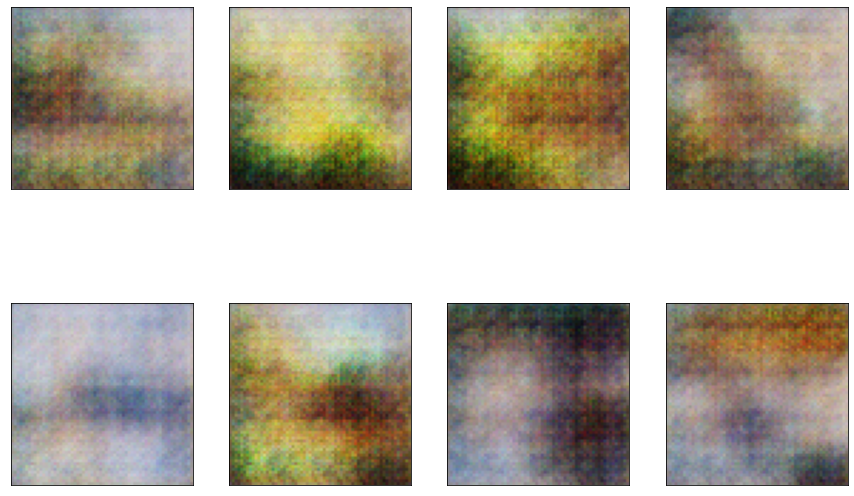

In [119]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), sample_result[EPOCHS-1]):
    _, w, h = img.size()
     
    img = img.detach().cpu().numpy()

    img = np.transpose(img, (1, 2, 0))
    
    img = ((img +1)*255 / (2)).astype(np.uint8)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    im = ax.imshow(img.reshape((w,h,3)))

plt.show()

##tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

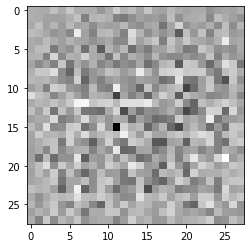

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')